#End-to-end CNN training script for CIFAR-10.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [36]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
df = yf.download("AAPL", start="2018-01-01", end="2024-12-31")


/tmp/ipython-input-1498049416.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [40]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.380989,40.390368,39.677733,39.888712,102223600
2018-01-03,40.373962,40.917816,40.310672,40.444289,118071600
2018-01-04,40.561493,40.664638,40.338796,40.446626,89738400
2018-01-05,41.023296,41.110030,40.566180,40.657604,94640000
2018-01-08,40.870926,41.166292,40.772467,40.870926,82271200


In [41]:
data = df[['Close']].values

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [43]:
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # lookback window (60 days)
X, y = create_sequences(scaled_data, time_step)

# Reshape input to (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [44]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (1359, 60, 1) Test shape: (340, 60, 1)


LSTM Model

In [45]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0596 - val_loss: 0.0030
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3906e-04 - val_loss: 0.0031
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.4348e-04 - val_loss: 0.0031
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.3447e-04 - val_loss: 0.0022
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9842e-04 - val_loss: 0.0029
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.8875e-04 - val_loss: 0.0027
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3936e-04 - val_loss: 0.0028
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1363e-04 - val_loss: 0.0033
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.5427e-04 - val_loss: 0.0013
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.5535e-04 - val_loss: 0.0016
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.7965e-04 - val_loss: 0.0025
Epoch 12/20
43/43 ━━━━━

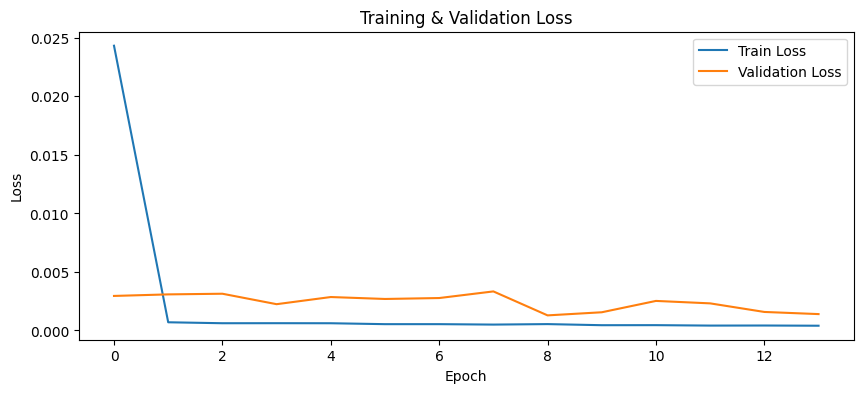

In [48]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


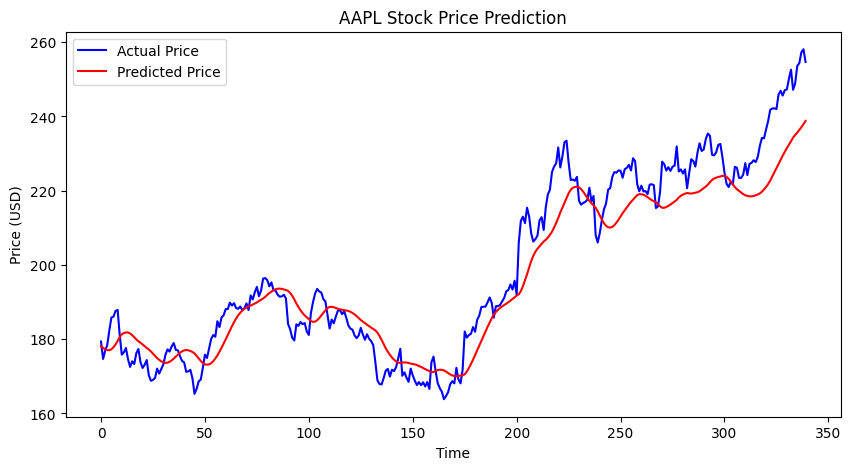

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Price', color='red')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [51]:
model.save('lstm_stock_model.h5')